In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [4]:
%%time
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2Past.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')

CPU times: user 6.85 s, sys: 14.2 s, total: 21.1 s
Wall time: 25 s


In [5]:
random_controls = pd.read_pickle('tempHybridSelectionMoreData/random.p')

In [6]:
pmpm.head(2)

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   

   CC_OSTEOPOROSIS  CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  LOB  PREGNANCY  IP_BIN  ER_BIN  ACUTE  IP_C  ER_C  ACUTE_C  IP_BIN6  ER_BIN6  ACUTE6  IP_BIN2  ER_BIN2  ACUTE2  
0              0.0            0.0             0.0          0.0                 0.0      0.0               0.0                     0.0             0.0              0.0        0.0         0.0                 0.0               0.0    1        0.0       0       0      0     0     0        0      0.0      0.0     0.0      0.0      0.0     0.0  
1              0.0            0.0             0.0          0.0                 0.0      0.0               0.0                     0.0             0.0              0.0        0.0         0.0                 0.0               0.0    1        0.0       0       0      0     0     0        0      0.0      0.0     0.0      0.0      0

#### Hierarchical Clustering
> Divide the Treated population in two clusters and study the <strong>Onset of Diabetes Onset</strong> separately in each of the clusters

In [7]:
unique = len(treated2.PERS_ID.unique())
clusters = int(unique**(1/2))
unique

In [8]:
clusters = 2
sec_id = ""

In [9]:
columns_to_match_hier = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

#columns_to_match_hier = ['AGE_AT_MIDMONTH',   'CC_TOBACCO',  'CC_OBESITY',
                  # 'CC_HYPERTENSION', 'CC_DX_CNT']


treated0, treated1, model, link_matr,  clustermapdat, treated22 = agglomerative(treated2.copy(),
                                                                                columns_to_match_hier ,
                                                                                n_clusters = clusters,
                                                                               filterpast = True)

In [10]:
treated22

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0     2602482  201908         0               81 -23.025851   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          1                    0.0          0.0              0.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1     2603072  202001         0               82   4.615121     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2     2606370  202010         0               82   3.135494     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            1.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            1.0                      0.0                0.0          0.0                0          5                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         1.0   
3 

In [11]:
treated3 = pd.merge(treated2, treated22[['PERS_ID', 'Group']],  on = 'PERS_ID')

#### Visualization of the clusters created in the previous step with a clustermap

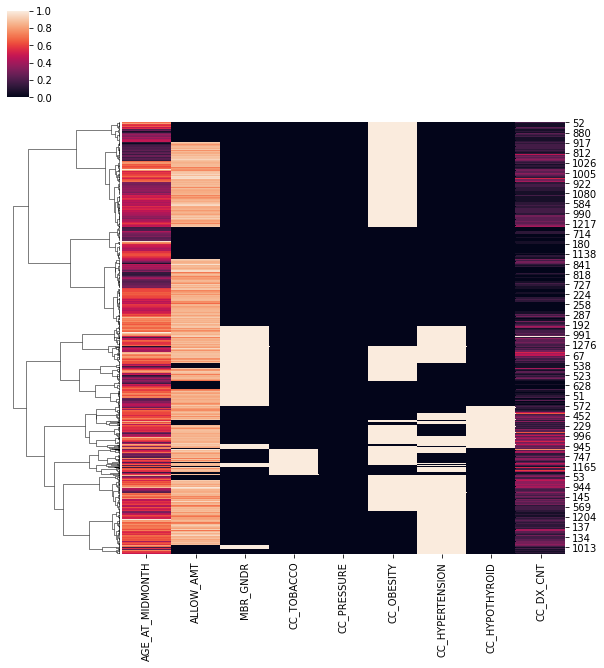

In [12]:
g = sns.clustermap(clustermapdat, method = 'ward', standard_scale=1, row_linkage = link_matr, col_cluster = False)

#### For each of the two clusters formed from the Treated patients form a matched population from the controls.
<div style="background:Aliceblue"> We use hier matching as our matching function</div>

In [13]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
match_on = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2']
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}


matched1, matched_data1 = matched_population(treated3.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

### Save data

In [14]:
pp = './tempNNhierAgglotheory{}Clusters{}/'.format(clusters, sec_id)
Path(pp).mkdir(exist_ok = True)
p1 = 'tempNNhierAgglotheory{}Clusters{}/'.format(clusters, sec_id)
#matched_data1.to_pickle(p+'match1.p')
#treated1.to_pickle(p+'treated1.p')

p = './tempNNhierAgglotheory/'


In [15]:
with open(p+'matchesPast.p', 'rb') as handle:
    matched1 = pickle.load(handle)


In [16]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [17]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [18]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

In [19]:
treat_test = treated22.copy()
treat_test.set_index('PERS_ID', inplace = True)
unique_groups = sorted(list(treat_test.Group.unique()))
len(unique_groups)

In [20]:
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

### Initialize groups

In [21]:
control_groups = {}
groups_id = {}
for group in unique_groups:
    control_groups[group] = pd.DataFrame()
    groups_id[group] = []

### Get For each group treated ids and matched controls

In [22]:
#controls_all = pd.DataFrame()

In [23]:
%%time
counter = 0
for (key, month), val in matched1.items():
    if len(val) < 5:
        counter += 1
        continue
    gt = treat_test.loc[key].Group
    val['RD'] = val.MYR
    #print(gt)
    #filt1 = controls
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    #new_dat = pd.merge(controls, val[['PERS_ID','RD']],  on = 'PERS_ID')
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)  
    new_dat['TR-MATCH'] = key
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    control_groups[gt] = pd.concat((control_groups[gt], new_dat2), ignore_index = True)
    #controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    groups_id[gt].append(key)
    counter += 1
    

CPU times: user 3min 52s, sys: 3.61 s, total: 3min 55s
Wall time: 3min 55s


In [24]:
#controls_all.to_pickle(pp_str+'controls_all.p')

In [25]:
treat_test.loc['2602482'].Group

1

In [26]:
len(groups_id[0]), len(groups_id[1]),  #groups[0].shape, groups[1].shape

### Get the treated data groups

In [27]:
from collections import defaultdict

treated_groups = {}
for group in groups_id:
    ids = groups_id[group]
    
    treated_groups[group] = treated3[treated3.PERS_ID.isin(ids)].reset_index(drop = True)

In [28]:
len(treated_groups[0].PERS_ID.unique()), len(treated_groups[1].PERS_ID.unique())

In [29]:
len(control_groups[0].PERS_ID.unique()), len(control_groups[1].PERS_ID.unique())

### Get the whole controls data

%%time
control_groups = {}
for group in groups:
    dat = groups[group]
    dat2 = dat[['PERS_ID', 'RD']]
    dat2 = dat2.drop_duplicates(subset = ['PERS_ID'], ignore_index = True)
    new_dat = pd.merge(controls, dat2, on = 'PERS_ID')
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    control_groups[group] = new_dat2
    

In [30]:
sv1 = p1+'cg{}{}.p'.format(clusters, sec_id)
with open(sv1, 'wb') as handle:
    pickle.dump(control_groups, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
sv2 = p1+'tg{}{}.p'.format(clusters, sec_id)
with open(sv2, 'wb') as handle:
    pickle.dump(treated_groups, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
control_groups[0]

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
0         26010351  202001         0               82        104     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          1.0                 0.0                    0.0                    0.0   
1         26010351  202002         0               82          1     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          1.0                 0.0                    0.0                    0.0   
2         26010351  202003         0               82          2     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          2                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
3         26010351  202004         

In [32]:
matched_data0, matched_data1 = control_groups[0],control_groups[1]
treated0, treated1 = treated_groups[0], treated_groups[1]

### Stats First Month(Treated and Matched Controls)

In [33]:
%%time
tr_desc0, treated_first_month0 = statistics_first_month(treated0, all_columns, return_array = True)
con_desc0, controls_first_month0 = statistics_first_month(matched_data0, all_columns, return_array = True)

tr_desc1, treated_first_month1 = statistics_first_month(treated1, all_columns, return_array = True)
con_desc1, controls_first_month1 = statistics_first_month(matched_data1, all_columns, return_array = True)

CPU times: user 3.81 s, sys: 56 ms, total: 3.86 s
Wall time: 3.87 s


### Stats First Month(General Pop and Random)

In [37]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 27s, sys: 7.71 s, total: 2min 35s
Wall time: 2min 35s


In [38]:
%%time
conds_first0, full_first0 = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols0, full_firstAllCols0 = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

conds_first1, full_first1 = stat_matrices(tr_desc1, con_desc1, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols1, full_firstAllCols1 = stat_matrices(tr_desc1, con_desc1, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 53.3 ms, sys: 157 µs, total: 53.5 ms
Wall time: 52.9 ms


## Statistics on matching date

In [39]:
conds_first0.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   54.170           54.267  -0.198  0.843             44.311   47.606
ALLOW_AMT        852.812          739.404   0.915  0.360           1065.926  648.803
MBR_GNDR           0.403            0.403   0.000  1.000              0.443    0.431
CC_TOBACCO         0.113            0.097   1.345  0.179              0.074    0.098
CC_PRESSURE        0.003            0.001   1.096  0.273              0.007    0.007
CC_OBESITY         0.485            0.474   0.532  0.595              0.109    0.228
CC_HYPERTENSION    0.651            0.617   1.744  0.081              0.208    0.249
CC_HYPOTHYROID     0.192            0.156   2.405  0.016              0.047    0.063
CC_DX_CNT          3.696            3.644   0.568  0.570              1.824    2.344
ACUTE2             0.060            0.050   1.034  0.301              0.063    0.052
ACUTE6             0.144            0.142   0.106  0.915              0.063    0.153
IP_BIN6            0.040            0.040   0.000  1.000              0.021    0.047
ER_BIN6            0.109            0.107   0.121  0.904              0.047    0.116
LOB                0.953            0.953   0.000  1.000              0.756    0.788

In [40]:
conds_first1.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   47.005           47.039  -0.065  0.948             44.311   47.606
ALLOW_AMT        542.835          525.206   0.300  0.764           1065.926  648.803
MBR_GNDR           0.000            0.000     NaN    NaN              0.443    0.431
CC_TOBACCO         0.000            0.006  -1.902  0.057              0.074    0.098
CC_PRESSURE        0.000            0.000  -0.447  0.655              0.007    0.007
CC_OBESITY         0.513            0.505   0.388  0.698              0.109    0.228
CC_HYPERTENSION    0.000            0.011  -2.698  0.007              0.208    0.249
CC_HYPOTHYROID     0.000            0.005  -1.793  0.073              0.047    0.063
CC_DX_CNT          2.014            2.011   0.037  0.970              1.824    2.344
ACUTE2             0.012            0.012   0.000  1.000              0.063    0.052
ACUTE6             0.068            0.069  -0.099  0.921              0.063    0.153
IP_BIN6            0.006            0.006   0.000  1.000              0.021    0.047
ER_BIN6            0.065            0.065   0.026  0.979              0.047    0.116
LOB                0.961            0.961   0.000  1.000              0.756    0.788

### Statistics Over all dates (treated, controls)

In [41]:
%%time
tr_desc0A = treated0[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

tr_desc1A = treated1[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc1A['count'] = tr_desc1A['count'].astype(int)

con_desc1A = matched_data1[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc1A['count'] = con_desc1A['count'].astype(int)

CPU times: user 1 s, sys: 0 ns, total: 1 s
Wall time: 1 s


### Statistics Over all dates (general population, Random)

In [ ]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

In [ ]:
%%time
conds0, full0 = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols0, full_AllCols0 = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

conds1, full1 = stat_matrices(tr_desc1A, con_desc1A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols1, full_AllCols1 = stat_matrices(tr_desc1A, con_desc1A, pmpm_descA, random_descA, columns = all_columns)

In [ ]:
conds0.round(3)

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [ ]:
columns_to_match

In [ ]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [ ]:
base_path =  './results/'+p1
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [ ]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [ ]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

In [ ]:
#%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month0.copy(), 
                 controls_first_month0.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures0/distributions_all/',
                dist_plot_args = dist_plot_args)

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month1.copy(), 
                 controls_first_month1.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures1/distributions_all/',
                dist_plot_args = dist_plot_args)

In [ ]:
#%%capture
dist_plot_args = {'hist':True}
axes0 = plot_hist(treated_first_month0.copy(), 
                 controls_first_month0.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures0/distributions_selection/',
                dist_plot_args = dist_plot_args)

dist_plot_args = {'hist':True}
axes1 = plot_hist(treated_first_month1.copy(), 
                 controls_first_month1.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures1/distributions_selection/',
                dist_plot_args = dist_plot_args)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [ ]:
arrays0 = [conds_first0, full_first0, conds_firstAllCols0, full_firstAllCols0,
         conds0, full0, conds_AllCols0, full_AllCols0]
arrays1 = [conds_first1, full_first1, conds_firstAllCols1, full_firstAllCols1,
         conds1, full1, conds_AllCols1, full_AllCols1]

names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']

names0 = [ nam+str(0) for nam in names]
names1 = [ nam+str(1) for nam in names]

save_arrays2(arrays0, names0, base_path+'tables0/stats/')
save_arrays2(arrays1, names1, base_path+'tables1/stats/')